In [1]:
import transformers as trf
import torch as pt
import numpy as np

import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
import tqdm
import json

from scipy.stats import spearmanr as Sr

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
class HeadlessBert(pt.nn.Module):
    def __init__(self, bert_variant='bert-base-uncased'):
        super(HeadlessBert, self).__init__()
        self.bert = trf.BertModel.from_pretrained(bert_variant)
        self.linear = pt.nn.Linear(self.bert.config.hidden_size, 
                                   self.bert.config.vocab_size, 
                                   bias=False)
        with pt.no_grad():
            self.linear.weight.copy_(self.bert.embeddings.word_embeddings.weight)

    def forward(self, X):
        return self.linear(self.bert(input_ids=X)[0])

In [3]:
class Add(pt.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.weight = pt.nn.Parameter(pt.zeros(size))
    
    def forward(self, X):
        return self.weight + X

class Scale(pt.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.weight = pt.nn.Parameter(pt.ones(size))
    
    def forward(self, X):
        return self.weight * X

In [4]:
class GeLU(pt.nn.Module):
    def __init__(self):
        super(GeLU, self).__init__()
        
    def forward(self, X):
        return pt.nn.functional.gelu(X)
    
class LMHead(pt.nn.Module):
    def __init__(self, bert_variant):
        super(LMHead, self).__init__()
        tmp = trf.BertForMaskedLM.from_pretrained(bert_variant)
        dense_w = pt.nn.Linear(tmp.config.hidden_size, 
                               tmp.config.hidden_size, 
                               bias=False)
        dense_b = Add(tmp.config.hidden_size)
        layernorm_c = pt.nn.LayerNorm(eps=tmp.config.layer_norm_eps,
                                normalized_shape=(tmp.config.hidden_size,))
        layernorm_w = Scale(tmp.config.hidden_size)
        layernorm_b = Add(tmp.config.hidden_size)
        decoder_w = pt.nn.Linear(tmp.config.hidden_size, 
                                 tmp.config.vocab_size, 
                                 bias=False)
        decoder_b = Add(tmp.config.vocab_size)
        with pt.no_grad():
            dense_w.weight.copy_(tmp.cls.predictions.transform.dense.weight)
            dense_b.weight.copy_(tmp.cls.predictions.transform.dense.bias)
            layernorm_w.weight.copy_(tmp.cls.predictions.transform.LayerNorm.weight)
            layernorm_b.weight.copy_(tmp.cls.predictions.transform.LayerNorm.bias)
            decoder_w.weight.copy_(tmp.cls.predictions.decoder.weight)
            decoder_b.weight.copy_(tmp.cls.predictions.decoder.bias)

        self.seq = pt.nn.Sequential(OrderedDict(
          [
              ('dense_weight', dense_w),
              ('dense_bias', dense_b),
              ('gelu', GeLU()),
              ('layernorm_center', layernorm_c),
              ('layernorm_scale', layernorm_w),
              ('layernorm_bias', layernorm_b),
              ('decoder_weight', decoder_w),
              ('decoder_bias', decoder_b)
          ]
        ))
        
    def forward(self, X):
        return self.seq(X)
        
class BertLMImpl(pt.nn.Module):
    def __init__(self, bert_variant='bert-base-uncased'):
        super(BertLMImpl, self).__init__()
        self.bert = trf.BertModel.from_pretrained(bert_variant)
        self.head = LMHead(bert_variant)
        
    def forward(self, X):
        return self.head(self.bert(input_ids=X)[0])

In [5]:
mybertlm = BertLMImpl()

In [6]:
tkr = trf.BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
wordembeddings = trf.BertForMaskedLM.from_pretrained('bert-base-uncased').bert.embeddings.word_embeddings.weight.detach().numpy()

In [8]:
def some_plots(name, orders_dict, values_dict):
    def wrapped(module, Xin):
        mask_in = Xin[0].squeeze()[mask_pos]
        if name not in ('decoder_bias',):
            dots = np.matmul(wordembeddings, mask_in)
            orders_dict[name] = np.argsort(dots)
            values_dict[name] = dots
        else:
            orders_dict[name] = np.argsort(mask_in)
            values_dict[name] = mask_in
    return wrapped

In [9]:
hooks_lm = {}
orders_lm = {}
values_lm = {}
for name, mod in mybertlm.head.seq.named_children():
    hooks_lm[name] = mod.register_forward_pre_hook(some_plots(name, orders_lm, values_lm))

In [10]:
data = []
path_to_conceptnet = '../data/ConceptNet/'
with open(f'{path_to_conceptnet}/test.jsonl', 'r') as f:
    for line in f.readlines():
        data.append(json.loads(line))

In [11]:
data_tks = list(tqdm.tqdm(map(lambda x: tkr.encode(x['masked_sentences'][0].replace("[MASK]", tkr.mask_token)), data)))

29774it [00:08, 3673.83it/s]


In [12]:
data_tks_targets = list(map(lambda x: x.index(tkr.mask_token_id), data_tks))

In [13]:
def spearmatr(matr):
    return np.array([[Sr(np.vstack([x, y]).T).correlation for y in matr] for x in matr]), \
           np.array([[Sr(np.vstack([x, y]).T).pvalue for y in matr] for x in matr])

In [20]:
corrs = []
with pt.no_grad():
    for tks, mask_pos in tqdm.tqdm(zip(data_tks, data_tks_targets)):
        orders_lm.clear()
        values_lm.clear()
        mybertlmout = mybertlm(pt.tensor(tks).unsqueeze(0))
        mybertlmout_values = mybertlmout.squeeze()[mask_pos]
        matr = np.vstack([
             mybertlmout_values,
             values_lm['dense_weight'],
             values_lm['dense_bias'],
             values_lm['gelu'],
             values_lm['layernorm_center'],
             values_lm['layernorm_scale'],   
             values_lm['layernorm_bias'],
             values_lm['decoder_weight'],
             values_lm['decoder_bias']])
        spearmatr_corr, _ = spearmatr(matr)
        corrs.append(spearmatr_corr[0, 1:-1])

29774it [9:40:20,  1.17s/it]


In [21]:
corrs_arr = np.vstack(corrs)

In [22]:
corrs_arr.shape


(29774, 7)

In [23]:
np.savetxt(X=corrs_arr, fname='corrs_arr.txt')

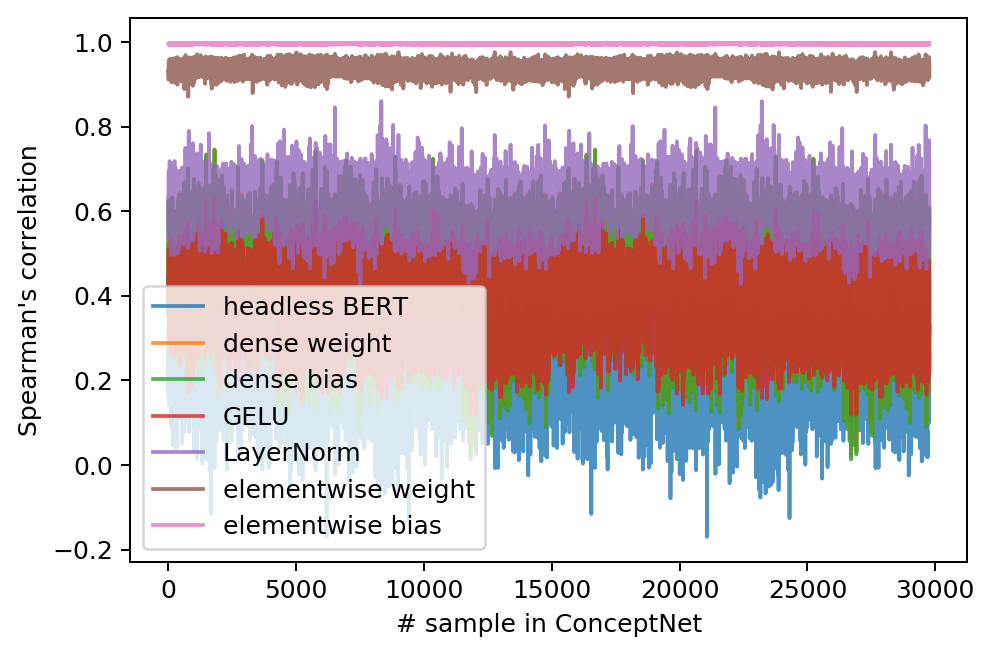

In [44]:
fig = plt.figure(dpi=180)
ax = fig.subplots()
labels = [
    'headless BERT',
    'dense weight',
    'dense bias',
    'GELU',
    'LayerNorm',
    'elementwise weight',
    'elementwise bias'
]
for i, l in enumerate(labels):
    ax.plot(corrs_arr[:, i], label=f"{l}", alpha=.8)
    ax.legend(loc='best')
    
ax.set_xlabel('# sample in ConceptNet')
ax.set_ylabel("""Spearman's correlation""")
fig.savefig('correlations-across-conceptnet.png')
plt.show()
plt.close(fig)

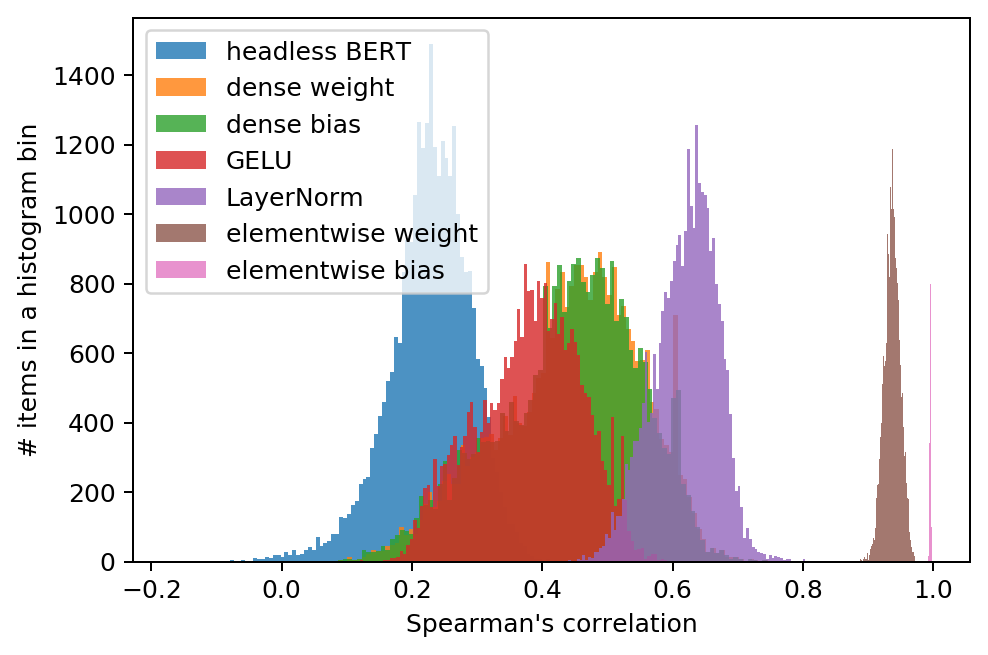

In [43]:
fig = plt.figure(dpi=180)
ax = fig.subplots()
labels = [
    'headless BERT',
    'dense weight',
    'dense bias',
    'GELU',
    'LayerNorm',
    'elementwise weight',
    'elementwise bias'
]
for i, l in enumerate(labels):
    ax.hist(corrs_arr[:, i], label=f"{l}", alpha=.8, bins=100)
    ax.legend(loc='best')
    
ax.set_xlabel("""Spearman's correlation""")
ax.set_ylabel("""# items in a histogram bin""")
plt.show()
fig.savefig('correlations-hist-conceptnet.png')
plt.close(fig)